### Step 1: Data Loading and Initial Exploration
Load the dataset and perform a quick inspection to understand the structure, check for missing values, and review the target class distribution.


In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.lrn.csv")

# Show the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Show descriptive statistics for numerical columns
print("\nDescriptive statistics:")
print(df.describe())

# Show general info about the dataset (column types, non-null counts)
print("\nInfo about the dataset:")
print(df.info())

# Show the number of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

# Show unique class distribution in the target variable
print("\nClass distribution in 'loan_status':")
print(df['loan_status'].value_counts())

First few rows of the dataset:
      ID  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0  24341    12500.0      12500.0          12500.0   36 months      7.21   
1  67534    33850.0      33850.0          33775.0   60 months     20.99   
2  35080    10000.0      10000.0          10000.0   60 months     20.00   
3   4828    20250.0      20250.0          20250.0   36 months     14.31   
4  59259    25000.0      25000.0          25000.0   36 months     14.99   

   installment emp_length home_ownership  annual_inc  ...  \
0       387.17   < 1 year       MORTGAGE     81000.0  ...   
1       915.57     1 year       MORTGAGE     80000.0  ...   
2       264.94   < 1 year           RENT     36580.0  ...   
3       695.15    9 years           RENT     48700.0  ...   
4       866.52     1 year       MORTGAGE     85000.0  ...   

  debt_settlement_flag issue_d_month issue_d_year earliest_cr_line_month  \
0                    N             6         2018                      6   

### Step 2: Prepare Features and Target for Grade Classification
Remove columns that could leak information and separate features (X) from the target variable (y = 'grade').


In [2]:
# Our goal is to predict 'grade'
# Remove columns that could cause data leakage
df_clean = df.copy()
drop_cols = [
    'ID', 'loan_status', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',
    'last_pymnt_d_month', 'last_pymnt_d_year',
    'last_credit_pull_d_month', 'last_credit_pull_d_year'
]
df_clean = df_clean.drop(columns=drop_cols)

# Define X and y for grade classification
X = df_clean.drop(columns=['grade'])
y = df_clean['grade']

print("Dataset successfully prepared for 'grade' classification.")
print(f"Number of samples: {X.shape[0]}, Number of features: {X.shape[1]}")
print("Target variable distribution (grade):")
print(y.value_counts())

Dataset successfully prepared for 'grade' classification.
Number of samples: 10000, Number of features: 76
Target variable distribution (grade):
grade
C    2989
B    2881
A    1821
D    1449
E     621
F     182
G      57
Name: count, dtype: int64


### Step 3: Define Features and Target
Create a cleaned dataset by removing potential data leakage columns, then separate features (X) from the target variable (y = 'grade').


In [3]:
# Make a copy of the original DataFrame
df_clean = df.copy()

# Define columns to drop
drop_cols = [
    'ID', 'loan_status',
    'total_pymnt', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',
    'last_pymnt_d_month', 'last_pymnt_d_year',
    'last_credit_pull_d_month', 'last_credit_pull_d_year'
]

# Drop columns that may cause data leakage
df_clean = df_clean.drop(columns=drop_cols)

# Define X and y
X = df_clean.drop(columns=['grade'])
y = df_clean['grade']

# Check shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10000, 76)
y shape: (10000,)


### Step 4: Check for Missing Values
Identify columns in the feature set (X) that contain missing values, sorted by frequency.


In [4]:
# Check the number of missing values per column
missing = X.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("Columns with missing values:\n")
print(missing)


Columns with missing values:

Series([], dtype: int64)


### Step 5: Identify Categorical Features
List all columns in the feature set (X) that have categorical (object) data types.

In [5]:
# Display categorical columns
cat_cols = X.select_dtypes(include='object').columns
print("Categorical columns:\n", cat_cols.tolist())


Categorical columns:
 ['term', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


Prepare the dataset by encoding categorical features using one-hot encoding and scaling numerical features with StandardScaler. After processing, numerical and non-numerical features are merged into a final dataset ready for modeling.


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# 0. Pretpostavka: originalni X još uvijek postoji kao dio df
X = df.drop(columns=["ID", "grade"])  # 'grade' je target

# 1. Log-transform prije dummy encodinga (na originalnim numeričkim kolonama)
X["annual_inc_log"] = np.log1p(X["annual_inc"])
X["revol_bal_log"] = np.log1p(X["revol_bal"])
X = X.drop(columns=["annual_inc", "revol_bal"])

# 2. One-hot encode svih kategorijskih kolona
categorical_cols = X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 3. Pregled podataka (opciono)
print("X_encoded shape:", X_encoded.shape)
print("Top NaN columns:\n", X_encoded.isnull().sum().sort_values(ascending=False).head(10))

# 4. Popunjavanje nedostajućih vrijednosti
X_encoded = X_encoded.fillna(0)

# 5. Skaliranje svih kolona (dummy + numeričke)
scaler = StandardScaler()
X_final = pd.DataFrame(
    scaler.fit_transform(X_encoded),
    columns=X_encoded.columns,
    index=X_encoded.index
)

# ✅ 6. Čišćenje imena kolona (da XGBoost ne pukne)
X_final.columns = (
    X_final.columns.astype(str)
    .str.replace(r"[\[\]<]", "", regex=True)
    .str.replace(" ", "_")
)

# 7. Završna provjera
print("✅ Final X_final shape:", X_final.shape)



X_encoded shape: (10000, 166)
Top NaN columns:
 loan_amnt          0
funded_amnt        0
funded_amnt_inv    0
int_rate           0
installment        0
dti                0
delinq_2yrs        0
fico_range_low     0
fico_range_high    0
inq_last_6mths     0
dtype: int64
✅ Final X_final shape: (10000, 166)


**Visualize Target Variable Distribution**

Plot the distribution of the target variable (`grade`) to observe class balance and detect any potential class imbalance issues.


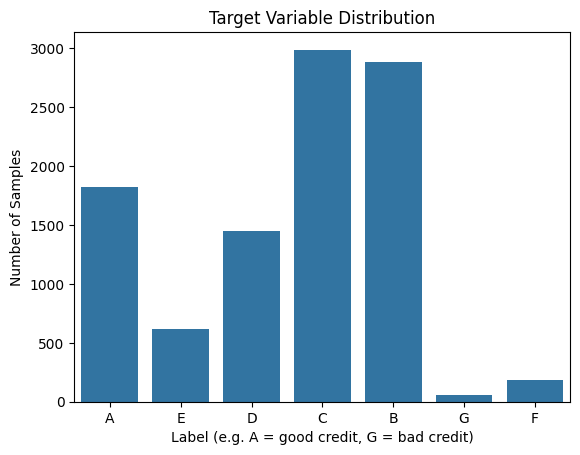

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target variable distribution
sns.countplot(x=y)
plt.title("Target Variable Distribution")
plt.xlabel("Label (e.g. A = good credit, G = bad credit)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

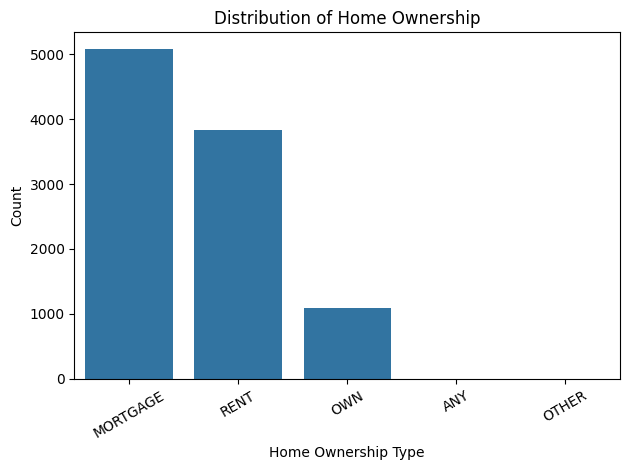

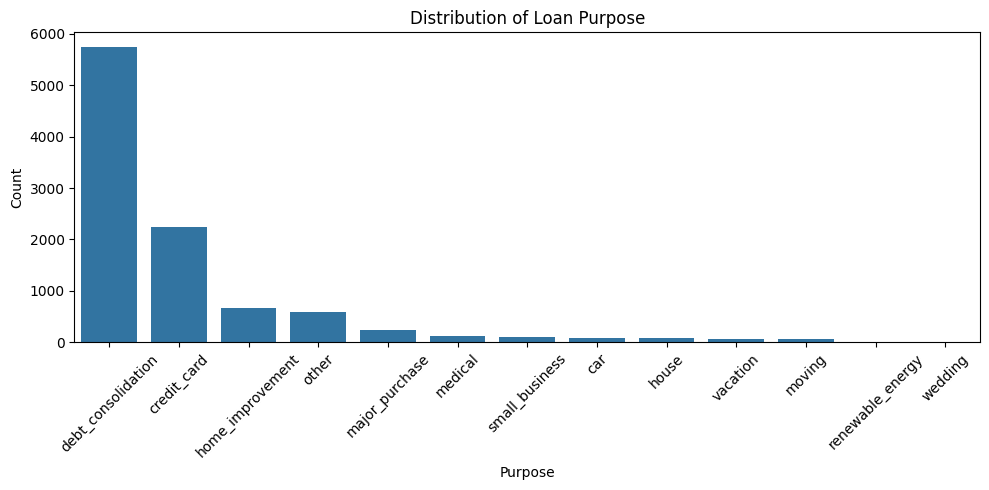

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of home ownership types
sns.countplot(data=df, x="home_ownership", order=df["home_ownership"].value_counts().index)
plt.title("Distribution of Home Ownership")
plt.xlabel("Home Ownership Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Distribution of loan purposes
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="purpose", order=df["purpose"].value_counts().index)
plt.title("Distribution of Loan Purpose")
plt.xlabel("Purpose")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

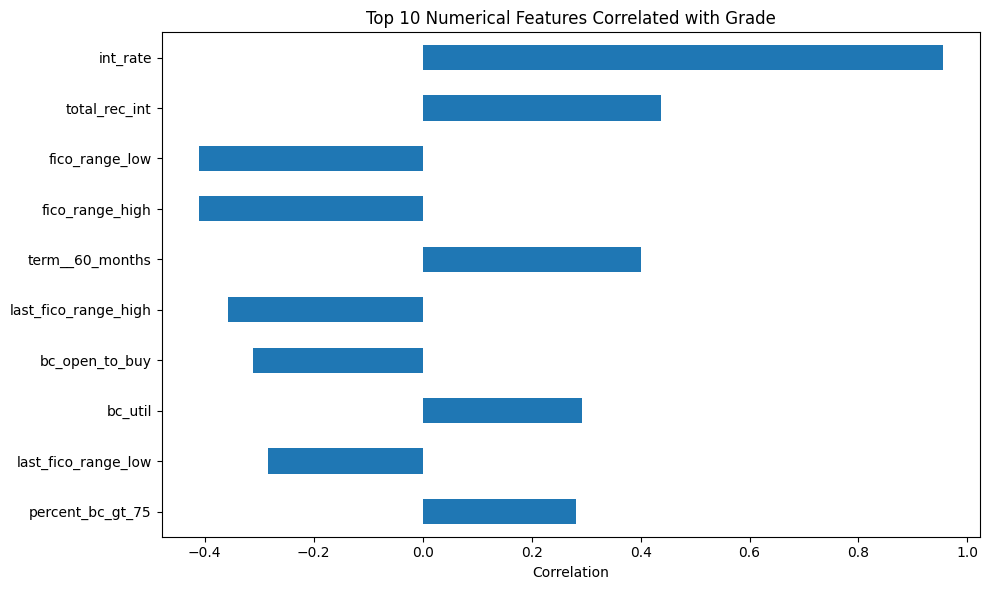

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert target labels (grade A-G) to numerical codes: A=0, ..., G=6
grade_numeric = y.astype("category").cat.codes

# Select only numeric columns from X_final
numerical_features = X_final.select_dtypes(include='number')

# Remove constant columns (zero standard deviation)
numerical_features = numerical_features.loc[:, numerical_features.std() > 0]

# Compute correlation with the target variable
correlations = numerical_features.corrwith(grade_numeric).sort_values(key=abs, ascending=False)

# Plot the top 10 most correlated features
plt.figure(figsize=(10, 6))
correlations[:10].plot(kind='barh')
plt.title("Top 10 Numerical Features Correlated with Grade")
plt.xlabel("Correlation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We analyzed the distribution of annual income across loan grades. The boxplot shows that higher credit grades (A, B) are associated with higher median incomes, while lower grades (F, G) generally correlate with lower income levels. This supports the hypothesis that income is a relevant factor for credit risk classification.

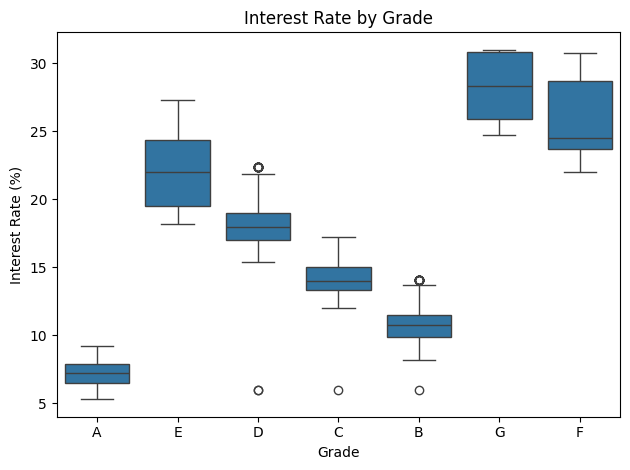

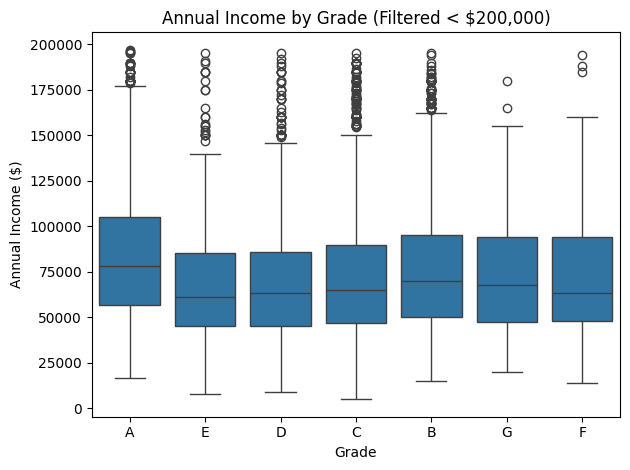

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Interest rate vs. grade
sns.boxplot(data=df, x='grade', y='int_rate')
plt.title("Interest Rate by Grade")
plt.xlabel("Grade")
plt.ylabel("Interest Rate (%)")
plt.tight_layout()
plt.show()

# Boxplot: Annual income vs. grade (filtered for better visibility)
sns.boxplot(data=df[df['annual_inc'] < 200000], x='grade', y='annual_inc')
plt.title("Annual Income by Grade (Filtered < $200,000)")
plt.xlabel("Grade")
plt.ylabel("Annual Income ($)")
plt.tight_layout()
plt.show()

### Log Transformation of Skewed Features

To reduce skewness and the impact of outliers, we applied log-transformation to two continuous features:
- `annual_inc` (annual income)
- `revol_bal` (revolving balance)

We used `np.log1p()` which is numerically stable and handles zero values. This helps models that assume approximately normal distributions and prevents large values from dominating the training process.

After transformation, the original columns were removed and replaced with the new log-transformed features.


**Log-Transform Skewed Features**

Apply log-transformation to `annual_inc` and `revol_bal` to reduce skewness and lessen the impact of extreme values. The original columns are dropped after transformation.


In [11]:
#import numpy as np

#Apply log-transformation to reduce skewness
#X_encoded['annual_inc_log'] = np.log1p(X_encoded['annual_inc'])
#X_encoded['revol_bal_log'] = np.log1p(X_encoded['revol_bal'])

#Drop the original untransformed columns
#X_encoded = X_encoded.drop(columns=['annual_inc', 'revol_bal'])


**Train-Test Split**

Split the fully preprocessed and scaled dataset (`X_final`) into training and test sets using an 80/20 ratio. Stratified sampling is used to preserve the class distribution of the target variable.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Split the final preprocessed dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Assign aliases for consistency with previous code
X_train_scaled = X_train
X_test_scaled = X_test

# 3. Encode target labels (e.g. A–G → 0–6)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 4. Confirm shapes
print("Train/Test split completed.")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_encoded shape:", y_train_encoded.shape)



Train/Test split completed.
X_train_scaled shape: (8000, 166)
X_test_scaled shape: (2000, 166)
y_train_encoded shape: (8000,)


**Train, Evaluate, and Compare Multiple Classifiers**

Train Logistic Regression, Random Forest, and XGBoost models using the scaled training data. Evaluate performance on the test set using accuracy, macro-averaged precision, recall, and F1-score. Measure training time and display results with confusion matrices and classification reports. Visualize key performance metrics for comparison.


In [13]:
print("NaN u X_final:", X_final.isnull().sum().sum())
print("NaN u X_train_scaled:", X_train_scaled.isnull().sum().sum())
print("NaN u X_test_scaled:", X_test_scaled.isnull().sum().sum())



NaN u X_final: 0
NaN u X_train_scaled: 0
NaN u X_test_scaled: 0



====== Logistic Regression ======
Training time: 1.07 seconds
Accuracy: 0.8620
Precision (macro): 0.6715
Recall (macro): 0.6617
F1-score (macro): 0.6651
Confusion Matrix:
 [[342  22   0   0   0   0   0]
 [ 20 520  36   0   0   0   0]
 [  0  34 534  30   0   0   0]
 [  0   0  36 235  18   0   1]
 [  0   0   0  31  82   8   3]
 [  0   0   0   0  21   9   7]
 [  0   0   0   0   0   9   2]]

Classification Report:
               precision    recall  f1-score   support

           A       0.94      0.94      0.94       364
           B       0.90      0.90      0.90       576
           C       0.88      0.89      0.89       598
           D       0.79      0.81      0.80       290
           E       0.68      0.66      0.67       124
           F       0.35      0.24      0.29        37
           G       0.15      0.18      0.17        11

    accuracy                           0.86      2000
   macro avg       0.67      0.66      0.67      2000
weighted avg       0.86      0.86      0.8

/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

Training time: 1.08 seconds
Accuracy: 0.9845
Precision (macro): 0.8834
Recall (macro): 0.8670
F1-score (macro): 0.8697
Confusion Matrix:
 [[361   3   0   0   0   0   0]
 [  0 576   0   0   0   0   0]
 [  0   3 590   5   0   0   0]
 [  0   0   1 288   1   0   0]
 [  0   0   0   2 119   3   0]
 [  0   0   0   0   2  32   3]
 [  0   0   0   0   0   8   3]]

Classification Report:
               precision    recall  f1-score   support

           A       1.00      0.99      1.00       364
           B       0.99      1.00      0.99       576
           C       1.00      0.99      0.99       598
           D       0.98      0.99      0.98       290
           E       0.98      0.96      0.97       124
           F       0.74      0.86      0.80        37
           G       0.50      0.27      0.35        11

    accuracy                           0.98      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.98      0.98      0.98      2000



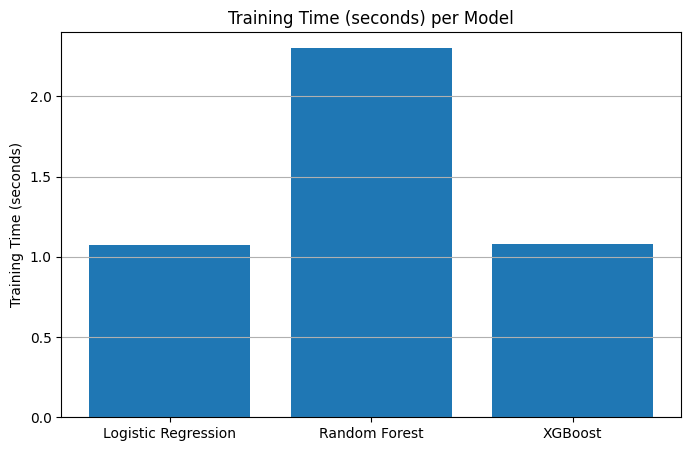

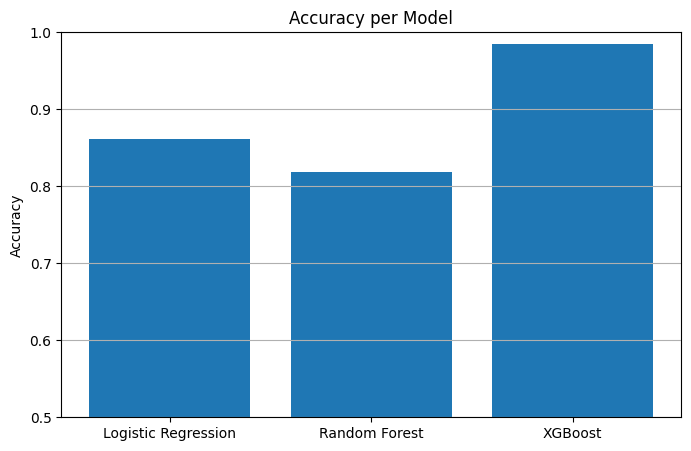

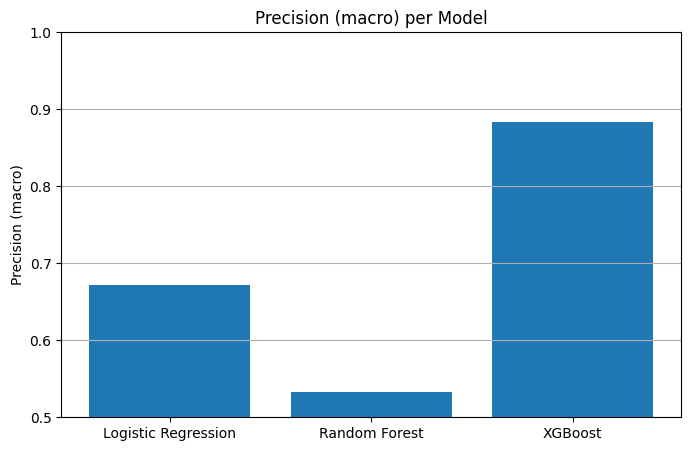

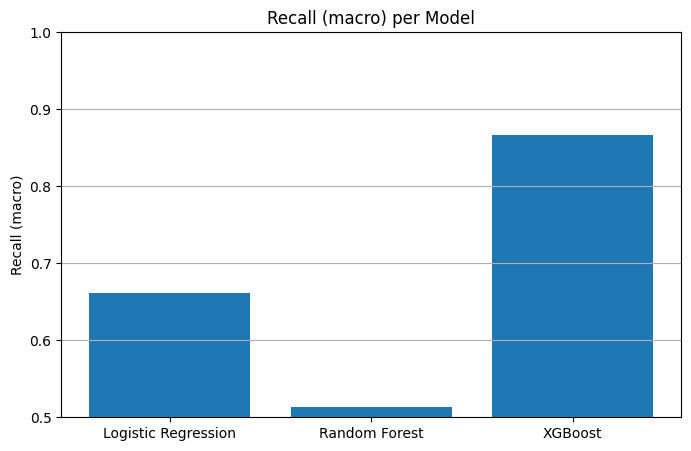

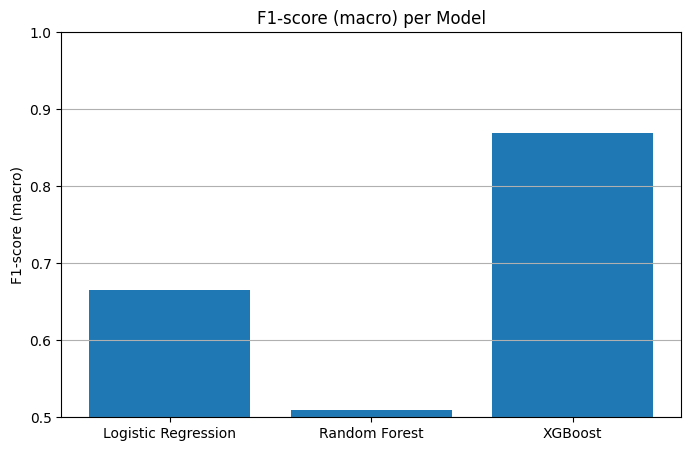

In [14]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode target labels (e.g. A–G → 0–6)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Helper: clean feature names
def clean_feature_names(df):
    df.columns = (
        df.columns.astype(str)
        .str.replace(r"[\[\]<]", "", regex=True)
        .str.replace(" ", "_")
    )
    return df

# Clean column names + fill NaNs (defensive)
X_train_safe = pd.DataFrame(X_train_scaled, columns=X_train_scaled.columns)
X_test_safe = pd.DataFrame(X_test_scaled, columns=X_train_scaled.columns)

X_train_safe = clean_feature_names(X_train_safe).fillna(0)
X_test_safe = clean_feature_names(X_test_safe).fillna(0)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
}

# Lists to store results
model_names = []
train_times = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training, prediction, and evaluation
for name, model in models.items():
    print(f"\n====== {name} ======")
    
    start_time = time.time()
    model.fit(X_train_safe, y_train_encoded)
    elapsed_time = time.time() - start_time

    y_pred = model.predict(X_test_safe)

    acc = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='macro', zero_division=0)

    model_names.append(name)
    train_times.append(elapsed_time)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Training time: {elapsed_time:.2f} seconds")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))
    print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# Visualization helper
def plot_metric(metric_values, metric_name, ylim=(0.5, 1.0)):
    plt.figure(figsize=(8, 5))
    plt.bar(model_names, metric_values)
    plt.title(f"{metric_name} per Model")
    plt.ylabel(metric_name)
    plt.ylim(ylim)
    plt.grid(axis='y')
    plt.show()

# Plot all metrics
plot_metric(train_times, "Training Time (seconds)", ylim=(0, max(train_times) + 0.1))
plot_metric(accuracies, "Accuracy")
plot_metric(precisions, "Precision (macro)")
plot_metric(recalls, "Recall (macro)")
plot_metric(f1_scores, "F1-score (macro)")


In [15]:
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))


Unique labels in y_test: ['A' 'B' 'C' 'D' 'E' 'F' 'G']
Unique labels in y_pred: [0 1 2 3 4 5 6]


### Confusion Matrices for All Models

To better understand the classification behavior of each model, we visualized their respective confusion matrices. These matrices show the number of correct and incorrect predictions for each class.

Since the target variable (`grade`) contains string labels from 'A' to 'G', we applied `LabelEncoder` to convert them into numeric form (0–6) for training. However, to keep the confusion matrix interpretable, we used the original string class names as tick labels for both axes.

Each heatmap below shows:
- Rows: actual labels (ground truth)
- Columns: predicted labels
- Cell values: number of instances

This helps identify which grades are often confused with others, and whether a model tends to under- or over-predict certain categories.


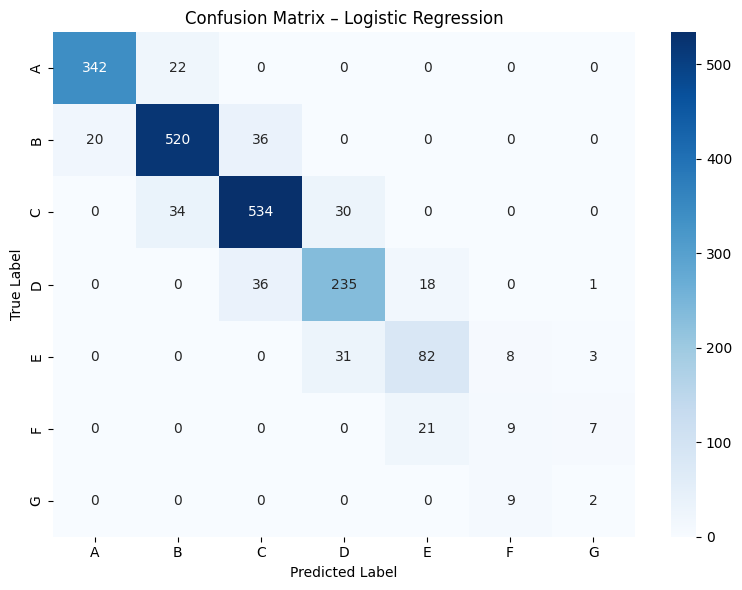

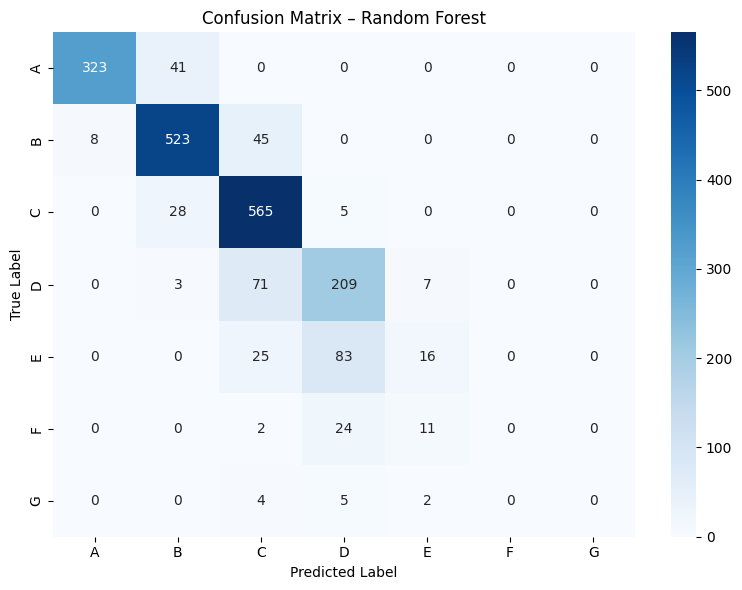

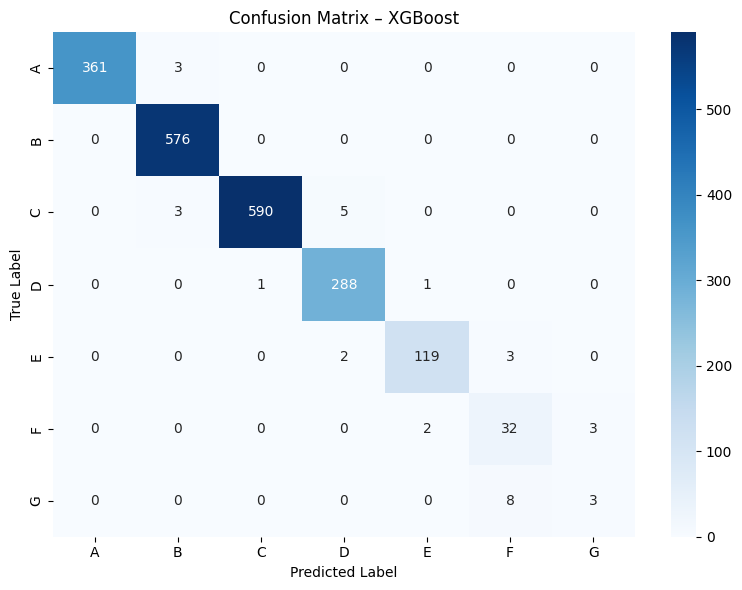

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix for each model
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)

    # Use encoded labels
    cm = confusion_matrix(y_test_encoded, y_pred, labels=range(len(le.classes_)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_,
                yticklabels=le.classes_)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix – {name}")
    plt.tight_layout()
    plt.show()



In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Define base Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 2️⃣ Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# 3️⃣ Setup GridSearchCV with 5-fold cross-validation and macro F1-score
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# 4️⃣ Train the grid search on the scaled training set
grid_search.fit(X_train_scaled, y_train)

# 5️⃣ Display best parameters
print("✅ Best hyperparameters found:")
print(grid_search.best_params_)

# 6️⃣ Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\n📊 Evaluation of the best Logistic Regression model:")
print(classification_report(y_test, y_pred, zero_division=0))

# 7️⃣ Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Best hyperparameters found:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

📊 Evaluation of the best Logistic Regression model:
              precision    recall  f1-score   support

           A       0.94      0.93      0.94       364
           B       0.75      0.74      0.74       576
           C       0.55      0.76      0.64       598
           D       0.38      0.22      0.28       290
           E       0.50      0.25      0.33       124
           F       0.27      0.11      0.15        37
           G       0.00      0.00      0.00        11

    accuracy                           0.66      2000
   macro avg       0.48      0.43      0.44      2000
weighted avg       0.64      0.66      0.64      2000

Confusion Matrix:
[[339  25   0   0   0   0   0]
 [ 21 424 131   0   0   0   0]
 [  0 118 453  25   0   2   0]
 [  0   2 211  64  10   2   1]
 [  0   0  22  65  31   5   1]
 [  0   0   1  13  14   4   5]
 [  0   0   0   2   7   2   0]]


In [18]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, make_scorer, f1_score
# from sklearn.preprocessing import LabelEncoder

# # Encode target labels (convert class labels to numeric form)
# le = LabelEncoder()
# y_train_encoded = le.fit_transform(y_train)
# y_test_encoded = le.transform(y_test)

# # Define the base Logistic Regression model
# log_reg = LogisticRegression(max_iter=5000, random_state=42)

# # Define the hyperparameter grid to search
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'],
#     'solver': ['liblinear', 'saga']
# }

# # Define the scoring metric for multiclass classification
# f1_macro = make_scorer(f1_score, average='macro')

# # Create and configure GridSearchCV with 10-fold cross-validation
# grid_search = GridSearchCV(
#     estimator=log_reg,
#     param_grid=param_grid,
#     cv=10,
#     scoring=f1_macro,
#     n_jobs=-1,
#     verbose=1
# )

# # Train the model using grid search
# grid_search.fit(X_train_scaled, y_train_encoded)

# # Display the best combination of hyperparameters found during grid search
# print("Best hyperparameters found:", grid_search.best_params_)

# # Use the best model to make predictions on the test set
# best_log_model = grid_search.best_estimator_
# y_pred = best_log_model.predict(X_test_scaled)

# # Evaluate the model's performance on the test set
# print("\nClassification report:\n")
# print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score

# 1. Define the base Random Forest model
rf = RandomForestClassifier(random_state=42)

# 2. Define hyperparameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 3. Define F1 macro scorer for multiclass classification
f1_macro = make_scorer(f1_score, average='macro')

# 4. Setup GridSearchCV with 5-fold cross-validation
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring=f1_macro,
    n_jobs=-1,
    verbose=1
)

# 5. Train using grid search with encoded labels
grid_rf.fit(X_train_scaled, y_train_encoded)

# 6. Evaluate the best model on the test set
print("Best Random Forest parameters:", grid_rf.best_params_)

best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

# 7. Classification report using original class labels
print("\nClassification report for best Random Forest:\n")
print(classification_report(y_test_encoded, y_pred_rf, target_names=le.classes_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Classification report for best Random Forest:

              precision    recall  f1-score   support

           A       0.98      0.89      0.93       364
           B       0.90      0.91      0.90       576
           C       0.78      0.96      0.86       598
           D       0.62      0.69      0.65       290
           E       0.39      0.10      0.15       124
           F       0.00      0.00      0.00        37
           G       0.00      0.00      0.00        11

    accuracy                           0.82      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.78      0.82      0.79      2000



/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score

# 1. Define the base XGBoost model (without deprecated parameter)
xgb = XGBClassifier(
    eval_metric='mlogloss',   # Required to avoid default error metric warning
    random_state=42
)

# 2. Define the hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],      # Number of trees
    'max_depth': [3, 5, 7],          # Tree depth
    'learning_rate': [0.05, 0.1]     # Step size shrinkage
}

# 3. Define the scorer for multiclass classification
f1_macro = make_scorer(f1_score, average='macro')

# 4. Set up GridSearchCV with 5-fold cross-validation
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring=f1_macro,
    n_jobs=-1,
    verbose=1
)

# 5. Fit the model on training data (with encoded target)
grid_xgb.fit(X_train_scaled, y_train_encoded)

# 6. Display best hyperparameters
print("Best XGBoost parameters:", grid_xgb.best_params_)

# 7. Predict using the best model
best_xgb_model = grid_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# 8. Evaluate using original class labels for readability
print("\nClassification report for best XGBoost model:\n")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

Classification report for best XGBoost model:

              precision    recall  f1-score   support

           A       1.00      0.99      1.00       364
           B       0.99      1.00      1.00       576
           C       1.00      1.00      1.00       598
           D       0.99      0.99      0.99       290
           E       0.95      0.95      0.95       124
           F       0.72      0.78      0.75        37
           G       0.33      0.18      0.24        11

    accuracy                           0.98      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.98      0.98      0.98      2000




===== Logistic Regression =====
Training time: 12.15 sec
Accuracy: 0.6575
Precision (macro): 0.4837
Recall (macro): 0.4291
F1-score (macro): 0.4404
Confusion Matrix:
 [[339  25   0   0   0   0   0]
 [ 21 424 131   0   0   0   0]
 [  0 118 453  25   0   2   0]
 [  0   2 211  64  10   2   1]
 [  0   0  22  65  31   5   1]
 [  0   0   1  13  14   4   5]
 [  0   0   0   2   7   2   0]]

Classification Report:
               precision    recall  f1-score   support

           A       0.94      0.93      0.94       364
           B       0.75      0.74      0.74       576
           C       0.55      0.76      0.64       598
           D       0.38      0.22      0.28       290
           E       0.50      0.25      0.33       124
           F       0.27      0.11      0.15        37
           G       0.00      0.00      0.00        11

    accuracy                           0.66      2000
   macro avg       0.48      0.43      0.44      2000
weighted avg       0.64      0.66      0.64    

/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:44:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 1.65 sec
Accuracy: 0.9850
Precision (macro): 0.8734
Recall (macro): 0.8589
F1-score (macro): 0.8635
Confusion Matrix:
 [[360   4   0   0   0   0   0]
 [  0 575   1   0   0   0   0]
 [  0   2 596   0   0   0   0]
 [  0   0   1 288   1   0   0]
 [  0   0   0   3 118   3   0]
 [  0   0   0   0   3  30   4]
 [  0   0   0   0   1   7   3]]

Classification Report:
               precision    recall  f1-score   support

           A       1.00      0.99      0.99       364
           B       0.99      1.00      0.99       576
           C       1.00      1.00      1.00       598
           D       0.99      0.99      0.99       290
           E       0.96      0.95      0.96       124
           F       0.75      0.81      0.78        37
           G       0.43      0.27      0.33        11

    accuracy                           0.98      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.98      0.98      0.98      2000



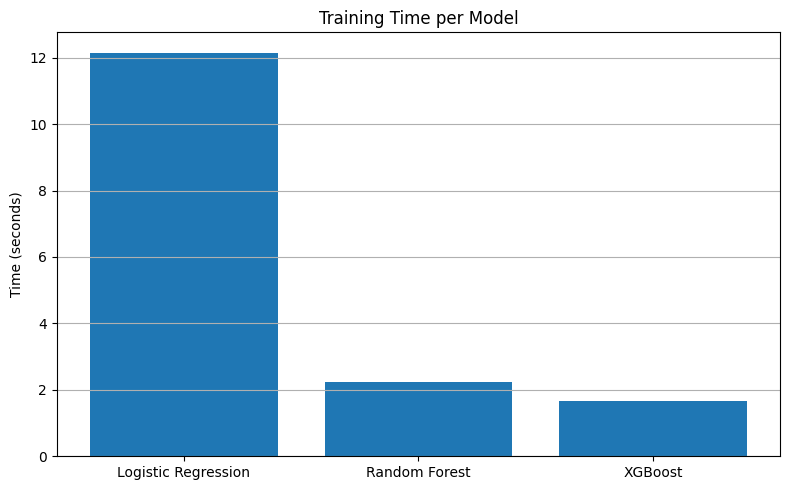

In [21]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assume these are already defined:
# X_train_scaled, X_test_scaled, y_train, y_test

# Label encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define final tuned models
best_models = {
    "Logistic Regression": LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=5,
                                            min_samples_leaf=1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.05,
                             eval_metric='mlogloss', use_label_encoder=False, random_state=42)
}

# Storage for plotting
model_names = []
train_times = []
accuracies = []
f1_scores = []

# Evaluation loop
for name, model in best_models.items():
    print(f"\n===== {name} =====")
    start_time = time.time()
    model.fit(X_train_scaled, y_train_encoded)
    elapsed_time = time.time() - start_time
    
    y_pred_enc = model.predict(X_test_scaled)
    y_pred = le.inverse_transform(y_pred_enc)
    y_true = y_test

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)

    model_names.append(name)
    train_times.append(elapsed_time)
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"Training time: {elapsed_time:.2f} sec")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

# Plot training time
plt.figure(figsize=(8, 5))
plt.bar(model_names, train_times)
plt.title("Training Time per Model")
plt.ylabel("Time (seconds)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Final Comparison Table:
                 Model Validation Method  F1-score
0  Logistic Regression         5-Fold CV  0.473227
1  Logistic Regression           Holdout  0.440422
2        Random Forest         5-Fold CV  0.496949
3        Random Forest           Holdout  0.509131
4              XGBoost         5-Fold CV  0.909470
5              XGBoost           Holdout  0.852743


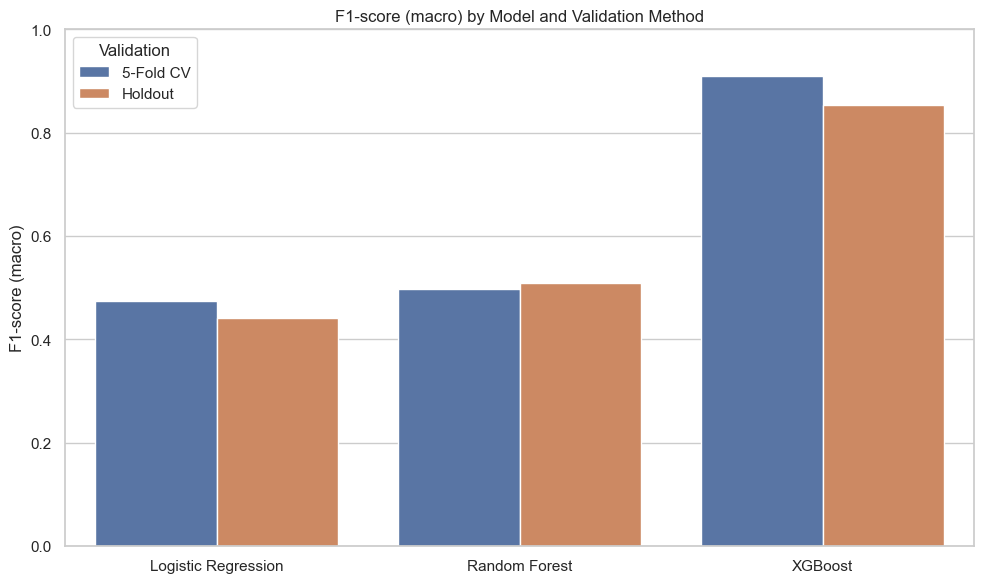

In [22]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Initialize results list
results = []

# Define macro F1 scorer for multiclass setting
f1_macro = make_scorer(f1_score, average='macro')

### ========== Logistic Regression ==========

logreg_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

logreg_cv = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logreg_param_grid,
    cv=5,
    scoring=f1_macro,
    n_jobs=-1,
    verbose=1,
    refit=True
)

logreg_cv.fit(X_train_scaled, y_train_encoded)
mean_f1_logreg_cv = logreg_cv.cv_results_['mean_test_score'][logreg_cv.best_index_]
y_pred_logreg_holdout = logreg_cv.best_estimator_.predict(X_test_scaled)
f1_logreg_holdout = f1_score(y_test_encoded, y_pred_logreg_holdout, average='macro')

results.append(["Logistic Regression", "5-Fold CV", mean_f1_logreg_cv])
results.append(["Logistic Regression", "Holdout", f1_logreg_holdout])

### ========== Random Forest ==========

rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf_cv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring=f1_macro,
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

rf_cv.fit(X_train_scaled, y_train_encoded)
mean_f1_rf_cv = rf_cv.cv_results_['mean_test_score'][rf_cv.best_index_]
y_pred_rf_holdout = rf_cv.best_estimator_.predict(X_test_scaled)
f1_rf_holdout = f1_score(y_test_encoded, y_pred_rf_holdout, average='macro')

results.append(["Random Forest", "5-Fold CV", mean_f1_rf_cv])
results.append(["Random Forest", "Holdout", f1_rf_holdout])

### ========== XGBoost ==========

xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1]
}

xgb_cv = GridSearchCV(
    estimator=XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring=f1_macro,
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

xgb_cv.fit(X_train_scaled, y_train_encoded)
mean_f1_xgb_cv = xgb_cv.cv_results_['mean_test_score'][xgb_cv.best_index_]
y_pred_xgb_holdout = xgb_cv.best_estimator_.predict(X_test_scaled)
f1_xgb_holdout = f1_score(y_test_encoded, y_pred_xgb_holdout, average='macro')

results.append(["XGBoost", "5-Fold CV", mean_f1_xgb_cv])
results.append(["XGBoost", "Holdout", f1_xgb_holdout])

### ========== Final Comparison Table ==========

results_df = pd.DataFrame(results, columns=["Model", "Validation Method", "F1-score"])
print("\nFinal Comparison Table:")
print(results_df)

### ========== Plotting ==========

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="Model",
    y="F1-score",
    hue="Validation Method"
)

plt.title("F1-score (macro) by Model and Validation Method")
plt.ylim(0.0, 1.0)
plt.ylabel("F1-score (macro)")
plt.xlabel("")
plt.legend(title="Validation")
plt.tight_layout()
plt.show()


In [23]:
!python3 -m pip install imbalanced-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import pandas as pd

print("Distribucija klasa (sa Pandas Series):\n", pd.Series(y_train).value_counts())




Distribucija klasa (sa Pandas Series):
 grade
C    2391
B    2305
A    1457
D    1159
E     497
F     145
G      46
Name: count, dtype: int64


In [25]:
# Import necessary librarie
    


In [26]:
df_test = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.tes.csv")
print(df_test.head())


      ID  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0   3582    10000.0      10000.0          10000.0   36 months      9.93   
1  60498    20000.0      20000.0          20000.0   60 months     13.67   
2  53227    15000.0      15000.0          15000.0   36 months     11.80   
3  21333    12500.0      12500.0          12500.0   36 months     15.31   
4   3885    19000.0      19000.0          19000.0   60 months     27.88   

   installment emp_length home_ownership  annual_inc  ... disbursement_method  \
0       322.35   < 1 year       MORTGAGE    130000.0  ...                Cash   
1       461.96  10+ years       MORTGAGE     75500.0  ...                Cash   
2       496.79   < 1 year           RENT     38000.0  ...                Cash   
3       435.22  10+ years       MORTGAGE     65000.0  ...                Cash   
4       590.21    6 years       MORTGAGE     38000.0  ...                Cash   

  debt_settlement_flag issue_d_month issue_d_year earliest_cr_

### Model Description

We trained a **default XGBoost classifier** (no hyperparameter tuning) to make baseline predictions.  
The test set was preprocessed using the same transformations as the training set: log-transformation, one-hot encoding, column alignment, and standardization.  
The model was trained on the preprocessed training data (`X_train_scaled`, `y_train_encoded`) and used to predict the `grade` variable on the test set.  
Predictions were decoded back to original labels and saved for submission.

In [27]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 1. Učitaj test skup
df_test = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.tes.csv")
ids = df_test["ID"]
df_test = df_test.drop(columns=["ID"])

# 2. Log-transformacije (kao kod trening skupa)
df_test["annual_inc_log"] = np.log1p(df_test["annual_inc"])
df_test["revol_bal_log"] = np.log1p(df_test["revol_bal"])
df_test = df_test.drop(columns=["annual_inc", "revol_bal"])

# 3. One-hot encoding
X_test_final = pd.get_dummies(df_test, drop_first=True)

# 4. Uskladi kolone sa trening skupom
missing_cols = set(X_encoded.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0
X_test_final = X_test_final[X_encoded.columns]

# 5. Skaliranje sa već treniranim scaler-om
X_test_final_scaled = scaler.transform(X_test_final)

# 6. Trenira se XGBoost sa default parametrima
final_xgb = XGBClassifier(
    eval_metric='mlogloss',   # ovo ostaje zbog warning-a u novijem XGBoost-u
    use_label_encoder=False,  # obavezno da se isključi warning kod novijih verzija
    random_state=42           # čisto da dobijemo ponovljive rezultate
)

final_xgb.fit(X_train_scaled, y_train_encoded)

# 7. Predikcija
y_pred_final_encoded = final_xgb.predict(X_test_final_scaled)

# 8. Prevedi nazad iz enkodovanih labela u 'A'–'G'
y_pred_final = le.inverse_transform(y_pred_final_encoded)

# 9. Kreiraj i snimi CSV za Kaggle
submission = pd.DataFrame({
    "ID": ids,
    "grade": y_pred_final
})
submission.to_csv("loan-10k-default.sol.csv", index=False)

print("Fajl 'loan-10k.sol.csv' uspešno kreiran za Kaggle submit!")


/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:45:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Fajl 'loan-10k.sol.csv' uspešno kreiran za Kaggle submit!


In [28]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 1. Učitaj test skup
df_test = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.tes.csv")
ids = df_test["ID"]
df_test = df_test.drop(columns=["ID"])

# 2. Log-transformacije (kao kod trening skupa)
df_test["annual_inc_log"] = np.log1p(df_test["annual_inc"])
df_test["revol_bal_log"] = np.log1p(df_test["revol_bal"])
df_test = df_test.drop(columns=["annual_inc", "revol_bal"])

# 3. One-hot encoding
X_test_final = pd.get_dummies(df_test, drop_first=True)

# 4. Uskladi kolone sa trening skupom
missing_cols = set(X_encoded.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0
X_test_final = X_test_final[X_encoded.columns]

# 5. Skaliranje sa već treniranim scaler-om
X_test_final_scaled = scaler.transform(X_test_final)

# 6. Trenira se XGBoost sa najboljim parametrima na celom trening skupu
final_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.05,
    eval_metric='mlogloss',
    random_state=42
)

final_xgb.fit(X_train_scaled, y_train_encoded)

# 7. Predikcija
y_pred_final_encoded = final_xgb.predict(X_test_final_scaled)

# 8. Prevedi nazad iz enkodovanih labela u 'A'–'G'
y_pred_final = le.inverse_transform(y_pred_final_encoded)

# 9. Kreiraj i snimi CSV za Kaggle
submission = pd.DataFrame({
    "ID": ids,
    "grade": y_pred_final
})
submission.to_csv("loan-10k.sol11111.csv", index=False)

print("Fajl 'loan-10k.sol.csv' uspešno kreiran za Kaggle submit!")


✅ Fajl 'loan-10k.sol.csv' uspešno kreiran za Kaggle submit!


### Model Description

We built an **ensemble model** using a **VotingClassifier** that combines an **XGBoost classifier** and a **Random Forest classifier**.  
The XGBoost model was configured with 100 trees, a maximum depth of 7, and a learning rate of 0.05, while the Random Forest model was set with 100 trees and a maximum depth of 20.  
**Soft voting** was used to combine the models, meaning that predicted class probabilities were averaged to make the final prediction.  
The ensemble was trained on the preprocessed training set and evaluated using classification metrics.  
Finally, predictions on the test set were made and saved for submission.

In [29]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# 1. Inicijalizuj najbolje trenirane modele (isti kao iz ranijeg GridSearch-a)
xgb_final = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.05,
    eval_metric='mlogloss',
    random_state=42
)

rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# 2. VotingClassifier sa soft votingom
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('rf', rf_final)
    ],
    voting='soft'  # koristi predict_proba
)

# 3. Treniraj ensemble
voting_clf.fit(X_train_scaled, y_train_encoded)

# 4. Predikcija i evaluacija
y_pred_voting = voting_clf.predict(X_test_scaled)

print("\n📊 Classification Report (VotingClassifier - soft voting):\n")
print(classification_report(y_test_encoded, y_pred_voting, target_names=le.classes_))

# 5. Ako hoćeš eksport:
y_pred_final_voting = le.inverse_transform(voting_clf.predict(X_test_final_scaled))

submission_voting = pd.DataFrame({
    "ID": ids,
    "grade": y_pred_final_voting
})
submission_voting.to_csv("loan-10k-voting.sol.csv", index=False)
print("✅ Voting submission saved as 'loan-10k-voting.sol.csv'")



📊 Classification Report (VotingClassifier - soft voting):

              precision    recall  f1-score   support

           A       1.00      0.99      0.99       364
           B       0.99      0.99      0.99       576
           C       0.99      1.00      0.99       598
           D       0.99      0.99      0.99       290
           E       0.95      0.95      0.95       124
           F       0.72      0.78      0.75        37
           G       0.33      0.18      0.24        11

    accuracy                           0.98      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.98      0.98      0.98      2000

✅ Voting submission saved as 'loan-10k-voting.sol.csv'


/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Model Description

We trained an **XGBoost classifier** on standardized and one-hot encoded data, using **sample weights** to balance the classes.  
The model was configured with 100 trees, a maximum depth of 7, a learning rate of 0.05, and evaluated using the **mlogloss** metric.  
After tuning, the final model was trained on the **full training set** to maximize learning before making predictions on the test set.  
Using the full training data is appropriate here because the goal is to generate final predictions for unseen test data, not to evaluate model performance.


In [30]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

# === 1. Trening skup ===
df_train = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.lrn.csv")
X = df_train.drop(columns=["ID", "grade"])
y = df_train["grade"]

# Log-transformacije
X["annual_inc_log"] = np.log1p(X["annual_inc"])
X["revol_bal_log"] = np.log1p(X["revol_bal"])
X = X.drop(columns=["annual_inc", "revol_bal"])

# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Label encoding ciljne promenljive
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Skaliranje
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_encoded)

# === 2. Treniranje finalnog XGBoost modela na celom skupu ===
final_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.05,
    eval_metric='mlogloss',
    random_state=42
)

final_xgb.fit(X_scaled, y_encoded, sample_weight=sample_weights)

# === 3. Test skup za predikciju ===
df_test = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.tes.csv")
ids = df_test["ID"]
df_test = df_test.drop(columns=["ID"])

# Ista obrada kao za trening skup
df_test["annual_inc_log"] = np.log1p(df_test["annual_inc"])
df_test["revol_bal_log"] = np.log1p(df_test["revol_bal"])
df_test = df_test.drop(columns=["annual_inc", "revol_bal"])
X_test_final = pd.get_dummies(df_test, drop_first=True)

# Usklađivanje kolona
missing_cols = set(X_encoded.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0
X_test_final = X_test_final[X_encoded.columns]

# Skaliranje test skupa
X_test_final_scaled = scaler.transform(X_test_final)

# === 4. Predikcija i eksport ===
y_pred_encoded = final_xgb.predict(X_test_final_scaled)
y_pred_labels = le.inverse_transform(y_pred_encoded)

submission = pd.DataFrame({
    "ID": ids,
    "grade": y_pred_labels
})
submission.to_csv("loan-10k.final-xgb.csv", index=False)
print("✅ Final XGBoost Kaggle file saved as 'loan-10k.final-xgb.csv'")


✅ Final XGBoost Kaggle file saved as 'loan-10k.final-xgb.csv'


### Model Description

We trained an **XGBoost classifier** using previously optimized hyperparameters (`n_estimators=100`, `max_depth=7`, `learning_rate=0.05`) to make final predictions.  
The test set was preprocessed using the same steps as the training set: log-transformation, one-hot encoding, column alignment, and standardization.  
The model was trained on already preprocessed training data (`X_train_scaled`, `y_train_encoded`) instead of starting from raw data.

**Important:**  
In this model, **no sample weights were used during training**. All classes were treated equally without balancing for class frequencies.

**Main difference compared to the full training workflow:**  
Unlike the version that processes raw data and applies class balancing (`sample_weight`), this approach skips recalculating sample weights and uses previously prepared training features to speed up training.

In [31]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 1. Učitaj test skup
df_test = pd.read_csv("/Users/hhodzic/Downloads/184-702-tu-ml-2025-s-loan/loan-10k.tes.csv")
ids = df_test["ID"]
df_test = df_test.drop(columns=["ID"])

# 2. Log-transformacije (kao kod trening skupa)
df_test["annual_inc_log"] = np.log1p(df_test["annual_inc"])
df_test["revol_bal_log"] = np.log1p(df_test["revol_bal"])
df_test = df_test.drop(columns=["annual_inc", "revol_bal"])

# 3. One-hot encoding
X_test_final = pd.get_dummies(df_test, drop_first=True)

# 4. Uskladi kolone sa trening skupom
missing_cols = set(X_encoded.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0
X_test_final = X_test_final[X_encoded.columns]

# 5. Skaliranje sa već treniranim scaler-om
X_test_final_scaled = scaler.transform(X_test_final)

# 6. Trenira se XGBoost sa tvojim najboljim parametrima
final_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.05,
    eval_metric='mlogloss',
    use_label_encoder=False,  # važno za novije verzije da ne baca warning
    random_state=42
)

final_xgb.fit(X_train_scaled, y_train_encoded)

# 7. Predikcija
y_pred_final_encoded = final_xgb.predict(X_test_final_scaled)

# 8. Prevedi nazad iz enkodovanih labela u 'A'–'G'
y_pred_final = le.inverse_transform(y_pred_final_encoded)

# 9. Kreiraj i snimi CSV za Kaggle
submission = pd.DataFrame({
    "ID": ids,
    "grade": y_pred_final
})
submission.to_csv("loan-10k22222.sol.csv", index=False)

print("✅ Fajl 'loan-10k.sol.csv' uspešno kreiran za Kaggle submit!")


/Users/hhodzic/jupyter_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:45:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Fajl 'loan-10k.sol.csv' uspešno kreiran za Kaggle submit!
